# Simulation Optimsiation using DES model of homeless response system

In [1]:
import datetime
print('Current version of this notebook updated ' + str(datetime.date.today()))

Current version of this notebook updated 2023-10-26


## Ranking & Selection

First we employ a Ranking & Selection algorithm based on the Kim & Nelson procedure. Details of this procedure can be found in section 9.3.2 (page 247) of 'Foundation and Methods of Stochastic Simulation' - Edition 2 (2021). The Python code for this procedure is found in the ranking_and_selection.py file in the GitHub repository. Below we import this module, and some others

In [2]:
# modules from this repository
import ranking_and_selection as rs
import simulation_model as sim
import queueing_model as qm

# external packages
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

### Testing using Inventory System

In order to test our KN procedure, we test it on a simulation model which has already been analysed using the KN algorithm in STOR-606 module - this is an $(s,S)$ inventory system where stock is replenished to a level of $S$ when it reaches $s$. 

In [3]:
solutions = [i for i in range(1600)]
k=np.array([i for i in range(1600)])

def simulate(solution):
    # one replication of simulating the cost of the inventory policy
    out=rs.InventorySystem(solution)[0]
    return out

In [4]:
random.seed(1)
opt_sols = []
for i in range(5):
    spc = rs.SolutionSpace(solutions)
    spc.optimise_rs(0.05, 50, 1, simulate, False)
    s,S = rs.get_sS_system(k[spc.active][0])
    opt_sols.append((s,S))

In [5]:
print('(s,S) for the optimal solution found at each iteration of the algorithm')
print(opt_sols)

(s,S) for the optimal solution found at each iteration of the algorithm
[(18, 52), (17, 53), (18, 53), (18, 54), (19, 53)]


The above illustrates that this KN algorithm can return different solutions when it is run at different times (i.e. with different starting seeds) - this is likely due to the difference between the true best and other good solutions being less than the 'delta' indiffference zone parameter used when running the algorithm above. 

### Developing a discrete solution space for the homeless response system

In [6]:
# solution space constraints
build_rate_options = {'housing' : [12, 24], 'shelter' : [12,24]}
annual_budget = 36
accommodation_budgets = {'housing' : 96, 'shelter' : 96}
build_rate_length_years = 5

# simulation options
number_reps = 1
initial_build_time = 63/365 # 9 weeks in years
initial_demand = 120
initial_capacity = {'housing' : 40, 'shelter' : 15}
arrival_rates = [35.0400, 42.0048, 46.2528, 46.2528, 41.6100] # in 1/year. One constant rate per year.
service_mean = {'housing' : (1/52)*(0+300+400)/3, 'shelter' : 0.0} # in years

# adjust arrival rates to include re-entries
reentry_rate = 0.17 # the proportion of those leaving accommodation which re-enter the system some time later
arrival_rate_reentries = (initial_capacity['housing']*reentry_rate)/service_mean['housing'] # assuming re-entries from the initial number of servers
arrival_rates = [i+arrival_rate_reentries for i in arrival_rates]#
time_btwn_changes_in_build_rate = (6*63)/365 # in years
time_btwn_building = 63/365 # in years. 63/365 years = 9 weeks.
reentry_rate = 0 # set this to zero now we have accounted for re-entries using an uplift to arrival rate

# additional params for analytical model
max_in_system = 1000
num_annual_buildpoints = 6
build_frequency_weeks = 9
d = 1 # days

# geneate solution space
sols = rs.generate_solution_space(build_rate_options, annual_budget, accommodation_budgets, build_rate_length_years)

Below we initialise a solution space object with the solutions we have generated

In [7]:
spc = rs.SolutionSpace(sols)

We next set a seed and then look for an optimal solution using the KN algorithm. A line of text is printed below whenever solutions are removed from the candidate list by the algorithm. 

In [8]:
random.seed(1)
spc.optimise_rs(0.05, 100, 0.74, sim.simulate_as_is, True)

starting routine at time  2023-10-26 19:05:23.296874
done init reps at time  2023-10-26 19:28:11.637945
start iteration 102 with 108 active solutions out of initial 221 at time 2023-10-26 19:28:25.440215
start iteration 103 with 107 active solutions out of initial 221 at time 2023-10-26 19:28:32.229866
start iteration 107 with 105 active solutions out of initial 221 at time 2023-10-26 19:28:58.922292
start iteration 108 with 104 active solutions out of initial 221 at time 2023-10-26 19:29:05.538381
start iteration 109 with 102 active solutions out of initial 221 at time 2023-10-26 19:29:12.034722
start iteration 110 with 100 active solutions out of initial 221 at time 2023-10-26 19:29:18.432583
start iteration 111 with 98 active solutions out of initial 221 at time 2023-10-26 19:29:24.635731
start iteration 112 with 97 active solutions out of initial 221 at time 2023-10-26 19:29:30.690710
start iteration 114 with 94 active solutions out of initial 221 at time 2023-10-26 19:29:42.810850

start iteration 543 with 9 active solutions out of initial 221 at time 2023-10-26 19:44:24.163209
start iteration 563 with 8 active solutions out of initial 221 at time 2023-10-26 19:44:35.575608
start iteration 712 with 7 active solutions out of initial 221 at time 2023-10-26 19:45:51.475270
start iteration 747 with 6 active solutions out of initial 221 at time 2023-10-26 19:46:07.097084
start iteration 869 with 5 active solutions out of initial 221 at time 2023-10-26 19:46:53.757839
start iteration 960 with 4 active solutions out of initial 221 at time 2023-10-26 19:47:22.802458
start iteration 1009 with 3 active solutions out of initial 221 at time 2023-10-26 19:47:35.343420
start iteration 1037 with 2 active solutions out of initial 221 at time 2023-10-26 19:47:40.800001


The details of the optimal solution are given below, followed by the following 20 solutions in decreasing order of the iteration number at which the KN algorithm removed them from the candidate list. 

In [9]:
# create dataframe
my_list = []
for i in range(len(sols)):
    my_dict = {}
    for index, element in enumerate(sols[i]['housing']):
        my_dict[index] = element
    for index, element in enumerate(sols[i]['shelter']):
        my_dict[index+5] = element
    my_dict[10] = spc.eliminate[i]
    my_dict[11] = np.mean(spc.costs[i])
    my_dict[12] = np.var(spc.costs[i])
    my_list.append(my_dict)
df_sim = pd.DataFrame.from_dict(my_list)
df_sim.columns = ['h1', 'h2', 'h3', 'h4', 'h5', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'iter_elim', 'sim_mean', 'sim_var']

In [10]:
# model analytically
outputs = []
for s in range(len(sols)):
    q = qm.queue(arrival_rates, service_mean['housing'], initial_capacity['housing'], initial_capacity['shelter'], [int(sols[s]['housing'][i]/num_annual_buildpoints) for i in range(len(sols[s]['housing']))], [int(sols[s]['shelter'][i]/num_annual_buildpoints) for i in range(len(sols[s]['shelter']))], initial_demand, max_in_system, num_annual_buildpoints, build_frequency_weeks)
    q.model_dynamics(4.75, d)
    outputs.append(q.num_unsheltered_avg)
    print('done ' + str(s) + ' at time ' + str(datetime.datetime.now()))

done 0 at time 2023-10-26 19:47:51.388116
done 1 at time 2023-10-26 19:48:00.172210
done 2 at time 2023-10-26 19:48:08.855129
done 3 at time 2023-10-26 19:48:17.684682
done 4 at time 2023-10-26 19:48:26.369049
done 5 at time 2023-10-26 19:48:35.023491
done 6 at time 2023-10-26 19:48:43.676072
done 7 at time 2023-10-26 19:48:52.330218
done 8 at time 2023-10-26 19:49:01.078229
done 9 at time 2023-10-26 19:49:09.833229
done 10 at time 2023-10-26 19:49:18.485823
done 11 at time 2023-10-26 19:49:27.157809
done 12 at time 2023-10-26 19:49:35.869577
done 13 at time 2023-10-26 19:49:44.542511
done 14 at time 2023-10-26 19:49:53.193676
done 15 at time 2023-10-26 19:50:01.895821
done 16 at time 2023-10-26 19:50:10.583866
done 17 at time 2023-10-26 19:50:19.212789
done 18 at time 2023-10-26 19:50:27.852795
done 19 at time 2023-10-26 19:50:36.500383
done 20 at time 2023-10-26 19:50:45.122444
done 21 at time 2023-10-26 19:50:53.761646
done 22 at time 2023-10-26 19:51:02.391923
done 23 at time 2023-

done 189 at time 2023-10-26 20:15:16.809959
done 190 at time 2023-10-26 20:15:25.482211
done 191 at time 2023-10-26 20:15:34.167885
done 192 at time 2023-10-26 20:15:42.854589
done 193 at time 2023-10-26 20:15:51.568273
done 194 at time 2023-10-26 20:16:00.338218
done 195 at time 2023-10-26 20:16:09.014497
done 196 at time 2023-10-26 20:16:17.719692
done 197 at time 2023-10-26 20:16:26.548366
done 198 at time 2023-10-26 20:16:35.224203
done 199 at time 2023-10-26 20:16:43.917818
done 200 at time 2023-10-26 20:16:52.586225
done 201 at time 2023-10-26 20:17:01.347845
done 202 at time 2023-10-26 20:17:10.082027
done 203 at time 2023-10-26 20:17:18.820914
done 204 at time 2023-10-26 20:17:27.620817
done 205 at time 2023-10-26 20:17:36.347069
done 206 at time 2023-10-26 20:17:45.016139
done 207 at time 2023-10-26 20:17:53.706604
done 208 at time 2023-10-26 20:18:02.481636
done 209 at time 2023-10-26 20:18:11.231615
done 210 at time 2023-10-26 20:18:19.938337
done 211 at time 2023-10-26 20:1

### Build rates of 12 or 24

#### Histogram of results

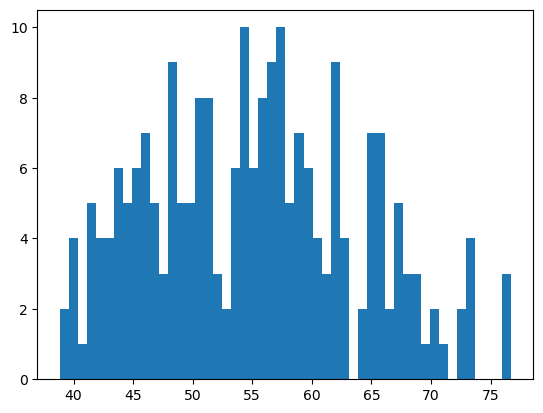

In [11]:
plt.hist(outputs,50)
plt.show()

#### Dataframe of results

In [12]:
my_list = []
for i in range(len(sols)):
    my_dict = {}
    for index, element in enumerate(sols[i]['housing']):
        my_dict[index] = element
    my_dict[5] = " "
    for index, element in enumerate(sols[i]['shelter']):
        my_dict[index+6] = element
    my_dict[11] = outputs[i]
    my_list.append(my_dict)
df_analytic = pd.DataFrame.from_dict(my_list)
df_analytic.columns = ['h1', 'h2', 'h3', 'h4', 'h5', ' ', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5', 'c']

In [13]:
df_concat = df_analytic.sort_values(by='c',ascending=True).reset_index(drop=True).merge(df_sim, on = ['h1', 'h2', 'h3', 'h4', 'h5', 'sh1', 'sh2', 'sh3', 'sh4', 'sh5'])
df_concat.style.apply(lambda x: ["background: pink" if v == 24 else "background: black" if v==' ' else "background: white" for v in x], axis = 1)

,h1,h2,h3,h4,h5,,sh1,sh2,sh3,sh4,sh5,c,iter_elim,sim_mean,sim_var
0,24,24,24,12,12,,12,12,12,24,24,38.858750,0,38.248875,77.584929
1,24,24,24,12,12,,12,12,12,24,12,39.309859,1052,39.545348,80.418034
2,24,24,12,24,12,,12,12,24,12,24,39.761206,1008,39.895244,79.520932
3,24,24,12,12,24,,12,12,24,24,12,40.106998,868,39.978436,84.802684
4,24,24,12,12,12,,12,12,24,24,24,40.130147,1036,39.817412,82.189766
5,24,24,12,24,12,,12,12,24,12,12,40.239052,959,40.059616,86.693304
6,24,24,12,12,12,,12,12,24,24,12,40.630380,746,40.696451,90.041338
7,24,12,24,24,12,,12,24,12,12,24,41.290395,711,41.294285,86.979625
8,24,24,24,12,12,,12,12,12,12,24,41.627747,508,41.709430,87.291890
9,24,12,24,12,24,,12,24,12,24,12,41.649947,496,41.447380,81.385895


#### Looking at improvements

In [14]:
low_val = 12
dims_all = ['h1','h2','h3','h4','h5','sh1','sh2','sh3','sh4','sh5']
list_imprv = [] # data on improvements
for dim in dims_all:
    for i in df_analytic[df_analytic[dim]==low_val].index.tolist():
        value_base = df_analytic.iloc[i]['c']
        conditions = dim + '''!=''' + str(low_val)
        for dim_compare in [dims_all[j] for j in range(len(dims_all)) if dims_all[j]!=dim]:
            conditions = conditions + ''' & ''' + dim_compare + '==' + str(df_analytic.iloc[i][dim_compare])
        df_analytic_with_conditions = df_analytic.query(conditions).reset_index(drop=True)
        if len(df_analytic_with_conditions) > 0:
            value_improve = df_analytic_with_conditions['c'][0]
            improvement = value_base - value_improve
            improvement = {'dim': dim,
                           'imprv': improvement}
            list_imprv.append(improvement)
        
df_imprv = pd.DataFrame.from_dict(list_imprv)

In [15]:
df_imprv_summary = df_imprv.groupby('dim').mean().reset_index()
df_imprv_summary

,dim,imprv
0,h1,16.115920
1,h2,11.290046
2,h3,7.073283
3,h4,3.459370
4,h5,0.600024
5,sh1,10.889196
6,sh2,8.265730
7,sh3,5.644167
8,sh4,3.022462
9,sh5,0.566134


#### Checking the analytical and simulation models agree on results

#### Build rates of 25 or 50

When the build rate options are 25 or 50, then in year 1, we either build 75 units of accommodation, which immediately clears the queue, or we build 50 units which doesn't immediately clear the queue, but at the next year does. 

In [16]:
build_rate_options1 = {'housing' : [24, 48], 'shelter' : [24, 48]}
annual_budget1 = 72
accommodation_budgets1 = {'housing' : 192, 'shelter' : 192}
simulation_length1 = 5

sols1 = rs.generate_solution_space(build_rate_options1, annual_budget1, accommodation_budgets1, simulation_length1)

# model analytically
outputs1 = []
for s in range(len(sols1)):
    q = qm.queue(arrival_rates, service_mean['housing'], initial_capacity['housing'], initial_capacity['shelter'], [int(sols1[s]['housing'][i]/num_annual_buildpoints) for i in range(len(sols1[s]['housing']))], [int(sols1[s]['shelter'][i]/num_annual_buildpoints) for i in range(len(sols1[s]['shelter']))], initial_demand, max_in_system, num_annual_buildpoints, build_frequency_weeks)
    q.model_dynamics(simulation_length1-0.25, d)
    outputs1.append(q.num_unsheltered_avg)
    print('done ' + str(s) + ' at time ' + str(datetime.datetime.now()))

done 0 at time 2023-10-26 20:20:02.876784
done 1 at time 2023-10-26 20:20:11.543542
done 2 at time 2023-10-26 20:20:20.051085
done 3 at time 2023-10-26 20:20:28.717157
done 4 at time 2023-10-26 20:20:37.302337
done 5 at time 2023-10-26 20:20:45.965959
done 6 at time 2023-10-26 20:20:54.524582
done 7 at time 2023-10-26 20:21:03.155046
done 8 at time 2023-10-26 20:21:11.779484
done 9 at time 2023-10-26 20:21:20.516877
done 10 at time 2023-10-26 20:21:29.222124
done 11 at time 2023-10-26 20:21:37.806117
done 12 at time 2023-10-26 20:21:46.615857
done 13 at time 2023-10-26 20:21:55.377074
done 14 at time 2023-10-26 20:22:04.073523
done 15 at time 2023-10-26 20:22:12.644640
done 16 at time 2023-10-26 20:22:21.201581
done 17 at time 2023-10-26 20:22:29.659372
done 18 at time 2023-10-26 20:22:38.420588
done 19 at time 2023-10-26 20:22:47.084597
done 20 at time 2023-10-26 20:22:55.676421
done 21 at time 2023-10-26 20:23:04.347157
done 22 at time 2023-10-26 20:23:12.920959
done 23 at time 2023-

done 189 at time 2023-10-26 20:47:09.956134
done 190 at time 2023-10-26 20:47:18.517651
done 191 at time 2023-10-26 20:47:27.064929
done 192 at time 2023-10-26 20:47:35.532849
done 193 at time 2023-10-26 20:47:44.230624
done 194 at time 2023-10-26 20:47:52.830498
done 195 at time 2023-10-26 20:48:01.340169
done 196 at time 2023-10-26 20:48:09.968120
done 197 at time 2023-10-26 20:48:18.607338
done 198 at time 2023-10-26 20:48:27.117415
done 199 at time 2023-10-26 20:48:35.654423
done 200 at time 2023-10-26 20:48:44.141971
done 201 at time 2023-10-26 20:48:52.798349
done 202 at time 2023-10-26 20:49:01.410010
done 203 at time 2023-10-26 20:49:09.957747
done 204 at time 2023-10-26 20:49:18.661217
done 205 at time 2023-10-26 20:49:27.262827
done 206 at time 2023-10-26 20:49:35.785754
done 207 at time 2023-10-26 20:49:44.322595
done 208 at time 2023-10-26 20:49:52.833541
done 209 at time 2023-10-26 20:50:01.497918
done 210 at time 2023-10-26 20:50:10.117329
done 211 at time 2023-10-26 20:5

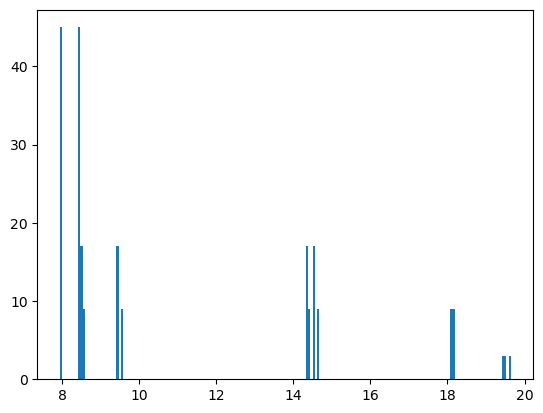

In [17]:
plt.hist(outputs1,200)
plt.show()